# Learning Best Practices for Model Evaluation and Hyperparameter Tuning

## Pipeline

In [27]:
# import breast cancer diagnosis data
import pandas as pd
df = pd.read_csv('wdbc.data',header=None)

In [28]:
# use label encoder 
from sklearn.preprocessing import LabelEncoder
X = df.loc[:,2:].values
y = df.loc[:,1].values

le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [29]:
# Split the data 80-20
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)

### Using the pipline

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(random_state=1))
pipe_lr.fit(X_train,y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test,y_test))

Test Accuracy: 0.956


## Hold-out and K-Fold Cross-Validation

In [31]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10,random_state=1).split(X_train,y_train) # generate indices

In [32]:
scores= []
for k, (train,test) in enumerate(kfold):
    pipe_lr.fit(X_train[train],y_train[train])
    score=pipe_lr.score(X_train[test],y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' %(k+1,np.bincount(y_train[train]),score))

print('\nCV accuracy: %.3f  %.3f' %(np.mean(scores),np.std(scores)))

Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956

CV accuracy: 0.950  0.014


In [34]:
# sklearn k-fold cv scorer
from sklearn.model_selection import  cross_val_score
scores = cross_val_score(estimator=pipe_lr,X=X_train,y=y_train,cv=10,n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('\nCV accuracy: %.3f  %.3f' %(np.mean(scores),np.std(scores)))

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]

CV accuracy: 0.950  0.014


# Debugging algorithms with learning and validation curves

In [35]:
# Learning Curve
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

In [36]:
pipe_lr = make_pipeline(StandardScaler(),LogisticRegression(penalty='l2',random_state=1))

In [38]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,X=X_train,y=y_train,train_sizes=np.linspace(0.1,1.0,10)
                                                       ,cv=10,n_jobs=1)

/home/wsun3/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:1103: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


In [39]:
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

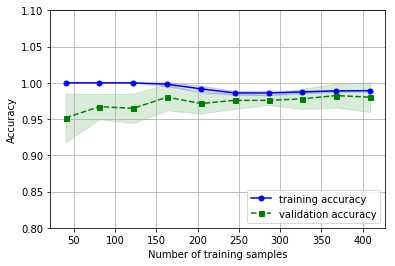

In [42]:
plt.plot(train_sizes,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.1])
plt.show()


## Validation Curve

In [44]:
from sklearn.model_selection import validation_curve

In [45]:
param_range = [0.001,0.01,0.1,1,10.0,100.0]

In [47]:
train_scores,test_scores = validation_curve(estimator=pipe_lr,X=X_train,y=y_train,param_name='logisticregression__C',
                                           param_range=param_range,cv=10)

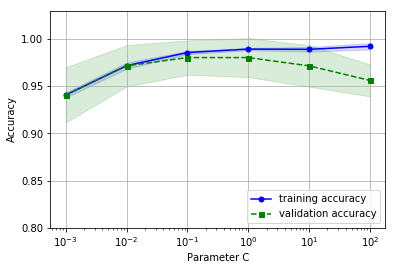

In [48]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean,
    color='blue', marker='o',
    markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std,
 train_mean - train_std, alpha=0.15,
 color='blue')
plt.plot(param_range, test_mean,
 color='green', linestyle='--',
 marker='s', markersize=5,
 label='validation accuracy')
plt.fill_between(param_range,
 test_mean + test_std,
 test_mean - test_std,
 alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()


## Fine tuning hyperparameters via grid search

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [56]:
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
param_range=[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [{'svc__C':param_range,'svc__kernel':['linear']},
              {'svc__C':param_range,'svc__gamma':param_range,'svc__kernel':['rbf']}]

In [57]:
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring='accuracy',cv=10,n_jobs=1)

In [59]:
gs = gs.fit(X_train,y_train)
print(gs.best_score_)

0.9846153846153847


In [60]:
print(gs.best_params_)

{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [61]:
clf = gs.best_estimator_
clf.fit(X_train,y_train)
print('Test accuracy: %.3f'% clf.score(X_test, y_test))


Test accuracy: 0.974


## Algorithm selection with nested CV

In [62]:
gs=GridSearchCV(estimator=pipe_svc,
param_grid=param_grid,
scoring='accuracy',
cv=2)
scores = cross_val_score(gs, X_train, y_train,
    scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
     np.std(scores)))


CV accuracy: 0.974 +/- 0.015


In [63]:
# Cmopare with random forest 
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(
random_state=0),
param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
scoring='accuracy',
cv=2)
scores = cross_val_score(gs, X_train, y_train,
scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
 np.std(scores)))


CV accuracy: 0.934 +/- 0.016


## Confusion Matrix

In [64]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test,y_pred=y_pred)
print(confmat)


[[71  1]
 [ 2 40]]


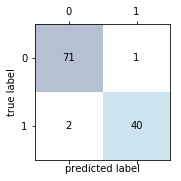

In [65]:
# visualize it using matshow
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
         s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()


In [66]:
# F1-Scores from sklearn metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
print('Precision: %.3f' % precision_score(
    y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(
 y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(
 y_true=y_test, y_pred=y_pred))


Precision: 0.976
Recall: 0.952
F1: 0.964


In [67]:
# make our own score
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,
param_grid=param_grid,
scoring=scorer,
cv=10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)


0.9880219137963148


In [68]:
print(gs.best_params_)

{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
